In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import tf_conversions

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/warning', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 

In [15]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


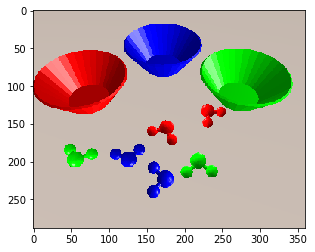

In [16]:
left_image = cv2.flip(left_image, 0)
plt.imshow(left_image)

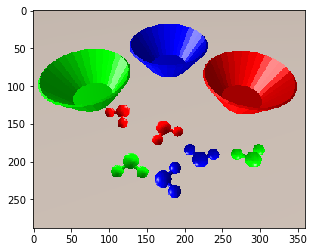

In [17]:
plt.imshow(right_image)

In [18]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 312511
  stamp: 
    secs: 1589257366
    nsecs: 711363554
  frame_id: "b"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 312511
  stamp: 
    secs: 1589257366
    nsecs: 711363554
  frame_id: "d"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 

In [19]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    suj = dvrk.suj('ECM')


In [20]:
psm1.get_current_position()

[[    0.438499,    0.142595,   -0.887347;
    -0.142602,    0.985864,    0.087957;
     0.887346,   0.0879681,    0.452635]
[     1.96062,    0.128979,   -0.802527]]

In [21]:
ecm.get_current_position()

[[          -1,-5.08674e-06,-7.26393e-06;
  -8.8679e-06,     0.57366,    0.819094;
  5.09929e-10,    0.819094,    -0.57366]
[ 3.68201e-06,    0.495891,    0.329076]]

In [22]:
suj.get_current_position()

[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]

[ERROR] [1589257369.513518]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6ace16e8d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



In [23]:
tf_listener = tf.TransformListener()

In [24]:
tf_listener.getFrameStrings()

['PSM1',
 'PSM2',
 'PSM3',
 'PSM1_tool_wrist_sca_ee_link_0',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'ecm_setup_link',
 'ecm_yaw_link',
 'PSM1_outer_pitch_top_link',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM1_outer_yaw_link',
 'ecm_pitch_link_1',
 'ecm_pitch_link_2',
 'ecm_pitch_link_3',
 'PSM1_tool_wrist_shaft_link',
 'PSM1_tool_wrist_sca_link',
 'PSM3_base',
 'PSM1_outer_insertion_link',
 'PSM1_tool_tip_link',
 'ECM_base',
 'ecm_insertion_link',
 'PSM1_outer_pitch_bottom_link',
 'ecm_base_link',
 'PSM1_tool_wrist_link',
 'PSM1_tool_main_link',
 'PSM1_tool_wrist_sca_shaft_link',
 'PSM1_psm_base_link',
 'ecm_roll_link',
 'PSM1_outer_pitch_back_link',
 'ecm_setup_base_link',
 'PSM1_base']

[INFO] [1589257383.565134]: Number of feature files:
[INFO] [1589257383.572978]: 1
[INFO] [1589257383.576325]: Feature ranges: 
[INFO] [1589257383.582490]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1589257383.620599]: 0
[INFO] [1589257383.625711]: Size: 3483.0
[INFO] [1589257383.635093]: Height: 288 Width: 360
[INFO] [1589257383.664021]: [x: 62.0
y: 193.0, x: 237.0
y: 147.0, x: 170.0
y: 121.0]
[INFO] [1589257383.700418]: [[ 62. 193.]
 [237. 147.]
 [170. 121.]]
[INFO] [1589257383.711431]: Size: 3816.0
[INFO] [1589257383.723106]: -78.8942272608
[INFO] [1589257383.731088]: Height: 288 Width: 360
[INFO] [1589257383.737312]: [x: 177.0
y: 165.0, x: 111.0
y: 139.0, x: 286.0
y: 92.0]
[INFO] [1589257383.744348]: [[177. 165.]
 [111. 139.]
 [286.  92.]]
[INFO] [1589257383.748513]: Size: 3826.0
[INFO] [1589257383.753807]: -32.3229677754
type: 
  data: "centroids"
center: 
  x: 156
  y: 153
zoom: 
  data: 0.912735849057
yaw_angle: 
  data: -1.37696402652
points: 
  - 
    x: 62.0
    y: 193.0

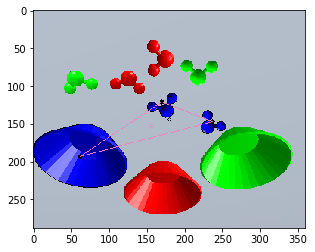

In [26]:
import image_geometry
import vision_pipeline
BALL_FEAT_PATH = '../autonomous_surgical_camera/auto_cam/config/features/red_ball.csv'
cv2.imwrite('left.png', left_image)
fp = vision_pipeline.feature_processor([BALL_FEAT_PATH], 'left.png')
left_feats, left_frame = fp.Centroids(left_image_msg)
right_feats, right_frame = fp.Centroids(right_image_msg)
print(left_feats)
plt.imshow(left_frame)

type: 
  data: "centroids"
center: 
  x: 191
  y: 132
zoom: 
  data: 0.910350235233
yaw_angle: 
  data: -0.564142211696
points: 
  - 
    x: 177.0
    y: 165.0
  - 
    x: 111.0
    y: 139.0
  - 
    x: 286.0
    y: 92.0


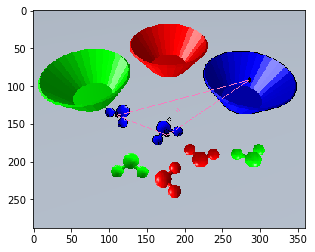

In [27]:
print(right_feats)
plt.imshow(right_frame)

[(226.0, 167.0), (51.0, 213.0), (118.0, 239.0)]
[(177.0, 165.0), (111.0, 139.0), (286.0, 92.0)]


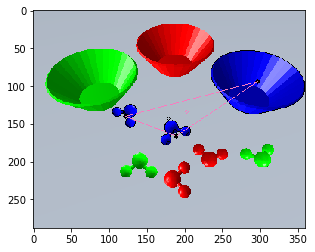

[ERROR] [1589257657.661768]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6a70021090>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589257674.381885]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6a70021090>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velo

In [37]:
left_cam = image_geometry.PinholeCameraModel()
left_cam.fromCameraInfo(left_camera_info)
right_cam = image_geometry.PinholeCameraModel()
right_cam.fromCameraInfo(right_camera_info)
left_frame_rectified = deepcopy(left_frame)

def rectify(cam, ros_pt):
    return tuple(cam.rectifyPoint((ros_pt.x, ros_pt.y)))

def invert_rectify(cam, ros_pt, frame_dims):
    return tuple(cam.rectifyPoint((frame_dims[0] - ros_pt.x, frame_dims[1] - ros_pt.y)))

left_feat_pts = [invert_rectify(left_cam, pt, left_frame.shape) for pt in left_feats.points]
right_feat_pts = [rectify(right_cam, pt) for pt in right_feats.points]
print(left_feat_pts)
print(right_feat_pts)
left_frame = cv2.flip(deepcopy(left_frame), 0)
left_cam.rectifyImage(left_frame, left_frame_rectified)
plt.imshow(left_frame_rectified)

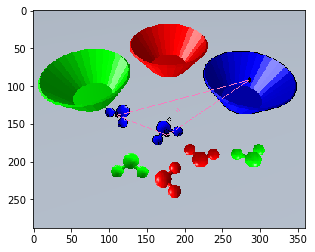

[ERROR] [1589257603.189486]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6ace16e8d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



In [32]:
right_frame_rectified = deepcopy(right_frame)
left_cam.rectifyImage(right_frame, right_frame_rectified)
plt.imshow(right_frame_rectified)

In [38]:
stereocam = image_geometry.StereoCameraModel()
stereocam.fromCameraInfo(left_camera_info, right_camera_info)
disparity = abs(left_feat_pts[1][0] - right_feat_pts[1][0])
stereocam.projectPixelTo3d(left_feat_pts[1], disparity)

(0.0, -0.0, -0.0)

[ERROR] [1589257681.219164]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6ace16e8d0>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False

[ERROR] [1589257716.202271]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f6a70021090>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity